In [1]:
using DelaySSAToolkit, Catalyst, DifferentialEquations, Plots, Latexify, StatsBase, LinearAlgebra

# Initiation time distribution

## Model reactions

In [2]:
# telegraph process

initiation = @reaction_network begin
    (k₁₂,k₂₁), S₁ <--> S₂
    k₂, S₂ --> ∅
end k₁₂ k₂₁ k₂;

In [3]:
# check species

Catalyst.species(initiation)

2-element Vector{Any}:
 S₁(t)
 S₂(t)

In [4]:
# check reactions

Catalyst.reactions(initiation)

3-element Vector{Reaction}:
 k₁₂, S₁ --> S₂
 k₂₁, S₂ --> S₁
 k₂, S₂ --> ∅

## Model parameters

In [6]:
# set parameter values [1/min]
k₁₂ = 0.001*60;
k₂₁ = 0.0007*60;
k₂ = 0.092*60;

## Stochastic simulations

In [7]:
# set model parameters
p = (k₁₂,k₂₁,k₂);

# set initial conditions
u₀ = [0,1];

# set time interval to solve on
ts = 1000.0;
tspan = (0.0,ts);

# define discrete problem
dprob = DiscreteProblem(u₀, tspan, p);

# define jump problem
jprob = JumpProblem(initiation, dprob, Direct())

# number of trajectories
ntraj = 10^6

# run SSA for multiple trajectories
ensprob = EnsembleProblem(jprob)
@time ens = solve(ensprob, SSAStepper(), EnsembleThreads(), trajectories=ntraj);

  5.223926 seconds (15.37 M allocations: 2.654 GiB, 42.32% gc time, 12.98% compilation time)


In [8]:
# get waiting times from individual trajectories
wtimes = [ens[n].t[end-1] for n=range(1,ntraj)]
mu = mean(wtimes)
println("Mean initiation time [min] = ",mu)
maxwt = maximum(wtimes)
print("Maximum initiation time [min] = ",maxwt)

Mean initiation time [min] = 0.30894267964066635
Maximum initiation time [min] = 142.17960561278986

In [13]:
# get the initiation time distribution f(t)
hwt = fit(Histogram, wtimes, closed=:left, 0:0.01:150)
hwtnorm = normalize(hwt,mode=:pdf)

Histogram{Float64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  0.0:0.01:150.0
weights: [5.3823, 5.055, 4.8294, 4.4989, 4.3062, 4.0914, 3.8513, 3.6423, 3.448, 3.2515  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
closed: left
isdensity: true

In [14]:
# export initiation time distribution to a table
using CSV
using DataFrames
wtSSA = DataFrame(t=hwtnorm.edges[1][1:end-1],f=hwtnorm.weights);

In [18]:
# export the table to a file
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="wt-dist-model-1-SSA.csv"

CSV.write(string(directory,"\\",filename), wtSSA, writeheader=false)

"C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal\\wt-dist-model-1-SSA.csv"

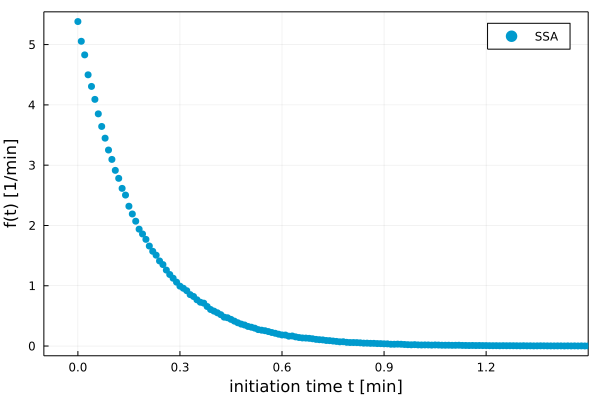

In [17]:
# plot the waiting time distributions

fig1=plot(wtSSA[!,1],wtSSA[!,2],
    seriestype=:scatter,
    xlims=(-0.1,1.5),
    xlabel="initiation time t [min]",
    ylabel="f(t) [1/min]",
    framestyle=:box,
    color="deepskyblue3",
    markerstrokecolor="deepskyblue3",
    label="SSA")

In [ ]:
# import exact data obtained by Mathematica

using CSV
using DataFrames
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="wt-dist-model-1-exact.csv"

wtexact = CSV.read(string(directory,"\\",filename), DataFrame, header=false);

In [ ]:
# add exact values to the plot

plot!(wtexact[!,1],wtexact[!,2],xlim=(0,20),line=2,color="deepskyblue3",label="exact")

In [ ]:
# export figure

# savefig(fig1, "wt-dist-Plec-K2.pdf")

# Transcription model

## Model reactions

In [19]:
transcription = @reaction_network begin
    (k₁₂,k₂₁), S₁ <--> S₂
    k₂, S₂ --> S₂+N
end k₁₂ k₂₁ k₂;

In [20]:
# check species

Catalyst.species(transcription)

3-element Vector{Any}:
 S₁(t)
 S₂(t)
 N(t)

In [21]:
# check reactions

Catalyst.reactions(transcription)

3-element Vector{Reaction}:
 k₁₂, S₁ --> S₂
 k₂₁, S₂ --> S₁
 k₂, S₂ --> S₂ + N

## Model parameters

In [22]:
# set parameter values [1/min]
# gene Zfp57 from the paper Mammalian Genes Are Transcribed with Widely Different Bursting Kinetics
k₁₂ = 0.001*60;
k₂₁ = 0.0007*60;
k₂ = 0.092*60;

# elongation parameters
L = 10000.0;
v = 2400.0;
T=L/v;

print("elongation time [min] = ",T)

elongation time [min] = 4.166666666666667

## Stochastic simulations

In [23]:
# set model parameters
p = (k₁₂,k₂₁,k₂)

# set initial conditions (K=2)
u₀ = [0,1,0]

# set time interval to solve on
ts = 200.0;
tspan = (0.0,ts)

# convert to jump problem
jumpsys = convert(JumpSystem, transcription, combinatoric_ratelaws = false)

# check states
states(jumpsys)

3-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 S₁(t)
 S₂(t)
 N(t)

In [24]:
# define discrete problem
dprob = DiscreteProblem(u₀, tspan, p)

# non-Markovian part
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], T)
end
delay_trigger = Dict(3=>delay_trigger_affect!) # 3 is the reaction that triggers delay
delay_complete = Dict(1=>[3=>-1]) # 1 is the first delay channel, [3=>-1] means that the third species is reduced by 1
delay_interrupt = Dict() 
delayjumpset = DelayJumpSet(delay_trigger,delay_complete,delay_interrupt)

# define delay problem
de_chan0 = [[]]
djprob = DelayJumpProblem(jumpsys, dprob, DelayRejection(), delayjumpset, de_chan0, save_positions=(false,false))


Number of constant rate jumps: 0
Number of variable rate jumps: 0
Have a mass action jump
Number of delay trigger reactions: 1
Number of delay interrupt reactions: 0


In [26]:
# number of individual trajectories
ntraj = 10^5

# run SSA for multiple trajectories
ensprob = EnsembleProblem(djprob)
@time ens = solve(ensprob, SSAStepper(), EnsembleThreads(), trajectories=ntraj);

137.739606 seconds (723.48 M allocations: 50.211 GiB, 9.89% gc time)


In [27]:
# get nascent RNA numbers from individual trajectories

ndata = [ens[n].u[end][end] for n=range(1,ntraj)];

In [28]:
# maximum number of nascent RNA

maxRNA=findmax(ndata)[1]

44

In [29]:
# get the nascent RNA distribution P(N=n)

hP = fit(Histogram, ndata, 0:maxRNA+1)
hPnorm = normalize(hP,mode=:pdf)

Histogram{Float64, 1, Tuple{UnitRange{Int64}}}
edges:
  0:45
weights: [0.32781, 0.00752, 0.00785, 0.00733, 0.00791, 0.00795, 0.00791, 0.0076, 0.00841, 0.00809  …  0.00208, 0.00161, 0.00083, 0.00054, 0.00033, 0.00015, 0.0001, 7.0e-5, 3.0e-5, 2.0e-5]
closed: left
isdensity: true

In [30]:
# export nascent RNA distribution to a table
using CSV
using DataFrames
PSSA = DataFrame(n=hPnorm.edges[1][1:end-1],P=hPnorm.weights)

,n,P
,Int64,Float64
1,0,0.32781
2,1,0.00752
3,2,0.00785
4,3,0.00733
5,4,0.00791
6,5,0.00795
7,6,0.00791
8,7,0.0076
9,8,0.00841


In [31]:
# export the table to a file

directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="nascent-RNA-dist-model-1-SSA.csv"
CSV.write(string(directory,"\\",filename), PSSA, writeheader=false)

"C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal\\nascent-RNA-dist-model-1-SSA.csv"

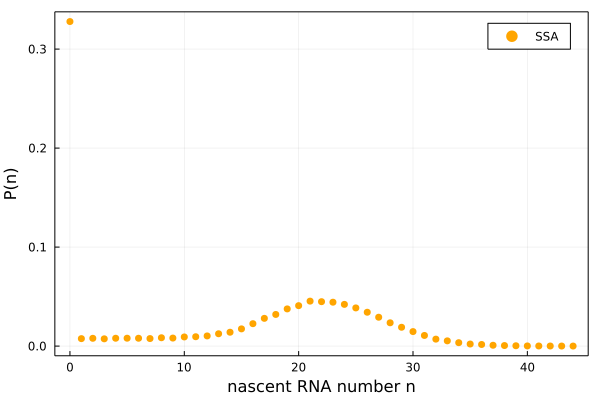

In [32]:
# plot the nascent RNA distribution

fig2=plot(PSSA[!,1],PSSA[!,2],
    seriestype=:scatter,
    xlabel="nascent RNA number n",
    ylabel="P(n)",
    framestyle=:box,
    label="SSA",
    color="orange",
    markerstrokecolor="orange")

In [ ]:
# import exact data obtained by Mathematica

using CSV
using DataFrames
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="nascent-RNA-dist-model-1-exact.csv"

Pexact = CSV.read(string(directory,"\\",filename), DataFrame, header=false);

In [ ]:
# add exact values to the plot

plot!(Pexact[!,1],Pexact[!,2],line=2,color="orange",label="exact")

In [ ]:
# export figure

# savefig(fig2, "nascent-RNA-dist-model-1.pdf")